
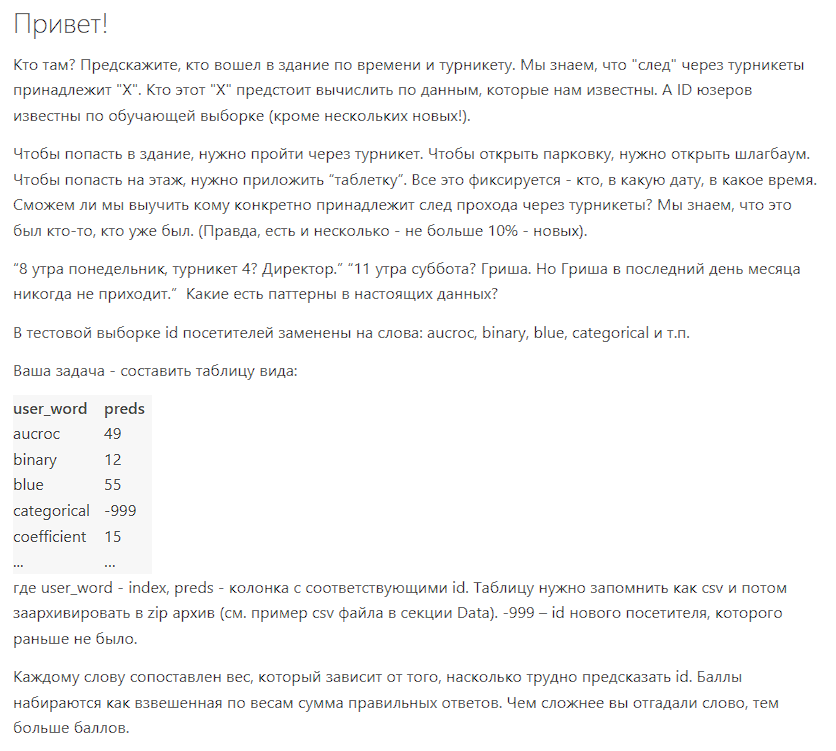

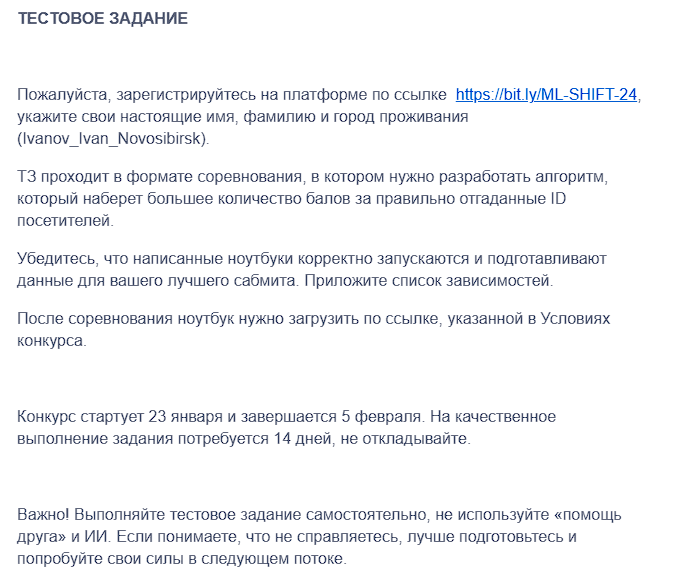

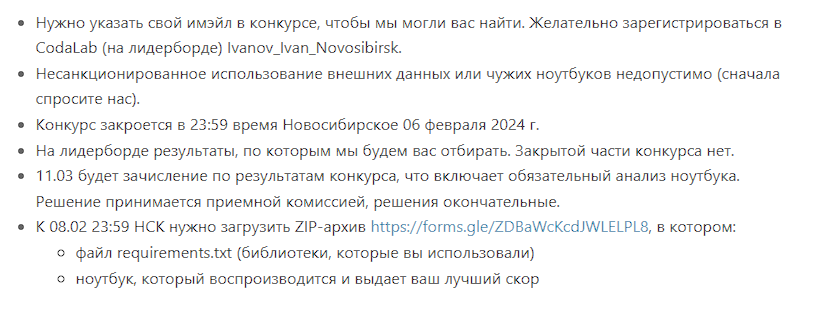

Импорт необходимых библиотек

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imb_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Зашрузка данных и их первичный анализ

In [2]:
# загрузка данных
submit = pd.read_csv('submit.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
# функция для проврки пропусков
def pass_value_barh(df):
    """
    Функция для наглядного представления пропусков в данных
    """
    try:
        (
            (df.isna().sum())
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось ')
checklist = ['submit', 'test', 'train']
for name in checklist:
    pass_value_barh(name)

пропусков не осталось 
пропусков не осталось 
пропусков не осталось 


Выведем информацию о данных

In [4]:
# общая информация о данных
print(submit.info(), end = '\n')
print(test.info(), end = '\n')
print(train.info(), end = '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_word  34 non-null     object
 1   preds      34 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 672.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7125 entries, 0 to 7124
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7125 non-null   int64 
 1   ts          7125 non-null   object
 2   gate_id     7125 non-null   int64 
 3   user_word   7125 non-null   object
dtypes: int64(2), object(2)
memory usage: 222.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37518 entries, 0 to 37517
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  37518 non-null  int64 
 1   user_id     37518 non-null  int64 
 2   ts    

In [5]:
# проврка на дубликаты 
print('Количество дубликатов в "data_1": ', test.duplicated().sum())
print('Количество дубликатов в "data_2": ', train.duplicated().sum())

Количество дубликатов в "data_1":  0
Количество дубликатов в "data_2":  0


Посмотрим на распределение целевого признака в train

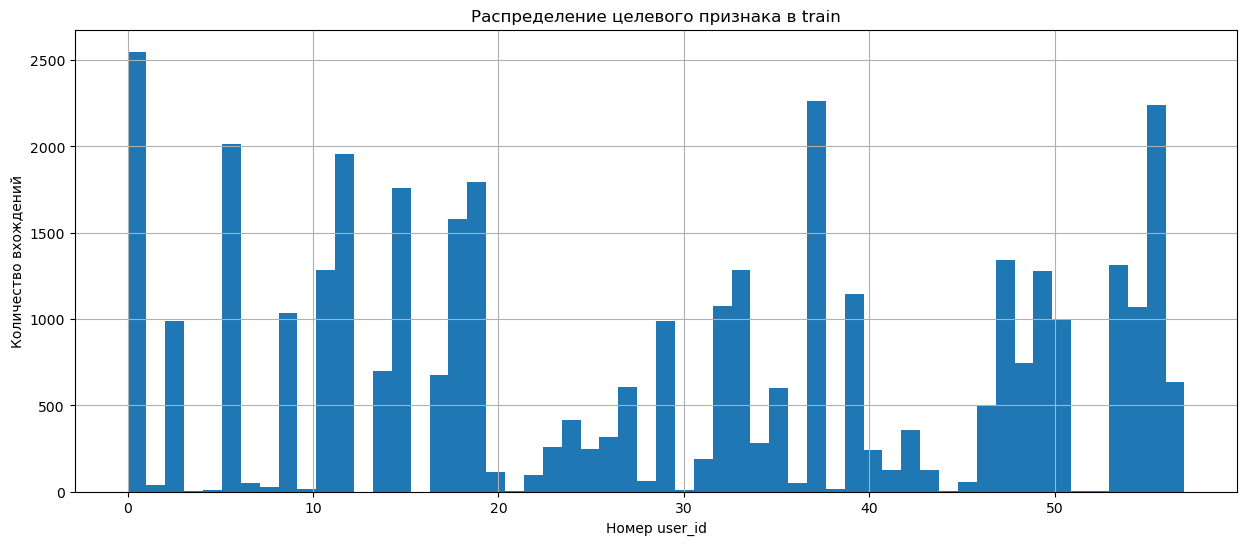

In [6]:
# график распределения
train.user_id.hist(bins=train.user_id.nunique(), figsize = (15, 6))
plt.title('Распределение целевого признака в train')
plt.xlabel('Номер user_id')
plt.ylabel('Количество вхождений')
plt.show()

In [7]:
# изменение формата данных
train['ts'] = pd.to_datetime(train['ts'], format = '%Y-%m-%d %H:%M:%S')
test['ts'] = pd.to_datetime(test['ts'], format = '%Y-%m-%d %H:%M:%S')

Необходимо проверить все ли gate_id присутствуют в train и test

In [8]:
# проверка и вывод недостающих
if sorted(list(train['gate_id'].unique())) != sorted(list(test['gate_id'].unique())):
    train_list = list(train['gate_id'].unique())
    test_list = list(test['gate_id'].unique())  
    print('Пропущенные gate_id', [x for x in train_list if x not in test_list] + [x for x in test_list if x not in train_list])
else:
    print('gate_id в train и test идентичны')

Пропущенные gate_id [0, 16, 2]


In [9]:
# посмотрим колшичество вхоэжений gate_id в train
train['gate_id'].value_counts().sort_index()

-1       48
 0        2
 1        5
 3     5351
 4     8170
 5     4619
 6     1800
 7     3026
 8       48
 9     3390
 10    4767
 11    4090
 12     698
 13    1201
 14       1
 15     298
 16       4
Name: gate_id, dtype: int64

In [10]:
# посмотрим колшичество вхоэжений gate_id в test
test['gate_id'].value_counts().sort_index()

-1        2
 1        2
 2        4
 3      909
 4     1459
 5      860
 6      294
 7      540
 8       18
 9      780
 10     915
 11     762
 12     132
 13     345
 14       1
 15     102
Name: gate_id, dtype: int64

In [11]:
# создадим список с id пропускных пунктов на удаление и удалим их функцией
list_gate_id_del = [-1, 0, 1, 2, 14, 16]
def del_gate(data, number_list):
    for i in number_list:
        data = data[data['gate_id'] != i]
    return data
train = del_gate(train, list_gate_id_del)
test = del_gate(test, list_gate_id_del)

In [12]:
# количесиво уникальных user_id в train и сколько раз они встречаются 
print('Уникальных user_id в train: ', train['user_id'].nunique())
train['user_id'].value_counts(ascending = False)

Уникальных user_id в train:  56


37    2262
55    2234
6     2011
12    1952
19    1793
15    1756
18    1578
47    1341
53    1311
1     1297
33    1285
11    1279
49    1275
0     1250
39    1144
32    1076
54    1070
9     1034
50     994
3      989
29     988
48     743
14     696
17     677
27     603
35     601
57     493
46     488
24     416
42     359
26     314
34     284
23     256
40     242
25     241
31     191
56     126
43     124
41     124
20     115
22      96
28      64
45      57
7       49
36      44
2       39
8       29
10      17
38      13
5       10
30      10
52       5
21       4
44       4
51       3
4        2
Name: user_id, dtype: int64

In [13]:
# количесиво уникальных user_word в test и сколько раз они встречаются 
print('Уникальных user_word в test: ', test['user_word'].nunique())
test['user_word'].value_counts(ascending = False)

Уникальных user_word в test:  34


f1              759
loss            497
sigmoid         446
binary          393
epsilon         371
collinear       329
x               318
independent     311
significant     292
gini            287
categorical     255
recall          229
predict         228
residual        228
r2              212
linear          211
fit             193
pvalue          186
matrix          166
ridge           150
ols             145
tstat           143
distributed     123
target          116
mse             107
minimization     99
coefficient      65
y                56
precision        56
regression       53
aucroc           41
lasso            34
blue             12
logistic          5
Name: user_word, dtype: int64

In [14]:
# проверка на дубликаты
print(f'Дубликаты в train: {train.duplicated().sum()}')
print(f'Дубликаты в test: {test.duplicated().sum()}')

Дубликаты в train: 0
Дубликаты в test: 0


Добавление новых признаков

In [15]:
def new_features_0(df):
    """
    Добавление первых признаков
    """
    df['day'] = df['ts'].dt.day
    df['weekday'] = df['ts'].dt.weekday
    df['hour'] = df['ts'].dt.hour
    df['minute'] = df['ts'].dt.minute
    df['week_number'] = df['ts'].dt.isocalendar().week
    
new_features_0(train)
new_features_0(test)

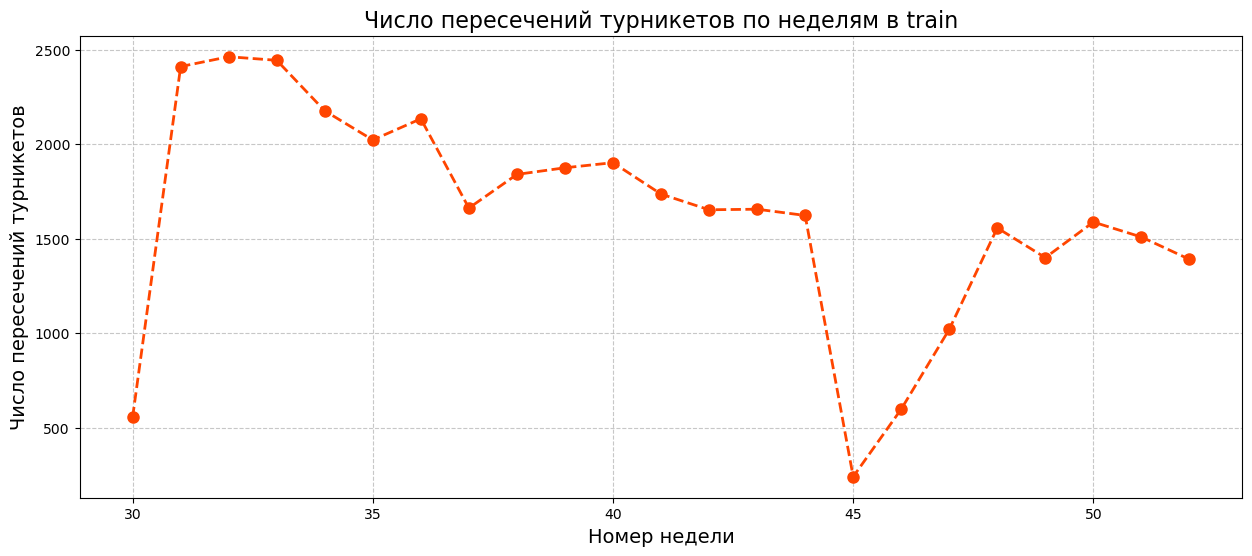

In [16]:
# Сортируем значения по номеру недели и строим график
plt.figure(figsize=(15, 6))
train['week_number'].value_counts().sort_index().plot(
    grid=True,
    color='orangered',
    linestyle='dashed', 
    marker='o',
    markersize=8, 
    linewidth=2  
)
plt.title('Число пересечений турникетов по неделям в train', fontsize=16)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Число пересечений турникетов', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

на 30, 45, 46, 47 неделе число проходов через турникет сильно меньше чем в остальные дни 

In [17]:
# функция для просмотра числа проходов по дням, показ начала и конец заданной недели
def show_week_number(week_count):
    print(f'-------------------------{week_count} неделя----------------------------------')
    print(train[train['week_number'] == week_count]['weekday'].value_counts().sort_index())
    print(f'Начало {week_count} недели: {train[train["week_number"] == week_count]["ts"].min()}')
    print(f'Конец {week_count} недели: {train[train["week_number"] == week_count]["ts"].max()}')
    
list_problem_week = [30, 45, 46, 47]
for i in list_problem_week:
    show_week_number(i)

-------------------------30 неделя----------------------------------
4    499
5     22
6     36
Name: weekday, dtype: int64
Начало 30 недели: 2022-07-29 09:08:54
Конец 30 недели: 2022-07-31 20:29:21
-------------------------45 неделя----------------------------------
0    178
4     42
6     22
Name: weekday, dtype: int64
Начало 45 недели: 2022-11-07 07:11:12
Конец 45 недели: 2022-11-13 23:28:42
-------------------------46 неделя----------------------------------
2     20
3    265
4    286
5     28
Name: weekday, dtype: int64
Начало 46 недели: 2022-11-16 15:04:59
Конец 46 недели: 2022-11-19 20:46:51
-------------------------47 неделя----------------------------------
0    262
1    257
2    251
3    240
6     11
Name: weekday, dtype: int64
Начало 47 недели: 2022-11-21 08:57:13
Конец 47 недели: 2022-11-27 15:33:21


In [18]:
# изменение типа данных
train = train.astype({'week_number': 'Int64'})

In [19]:
# удаление из данных 45 неделю
train = train[train['week_number'] != 45]

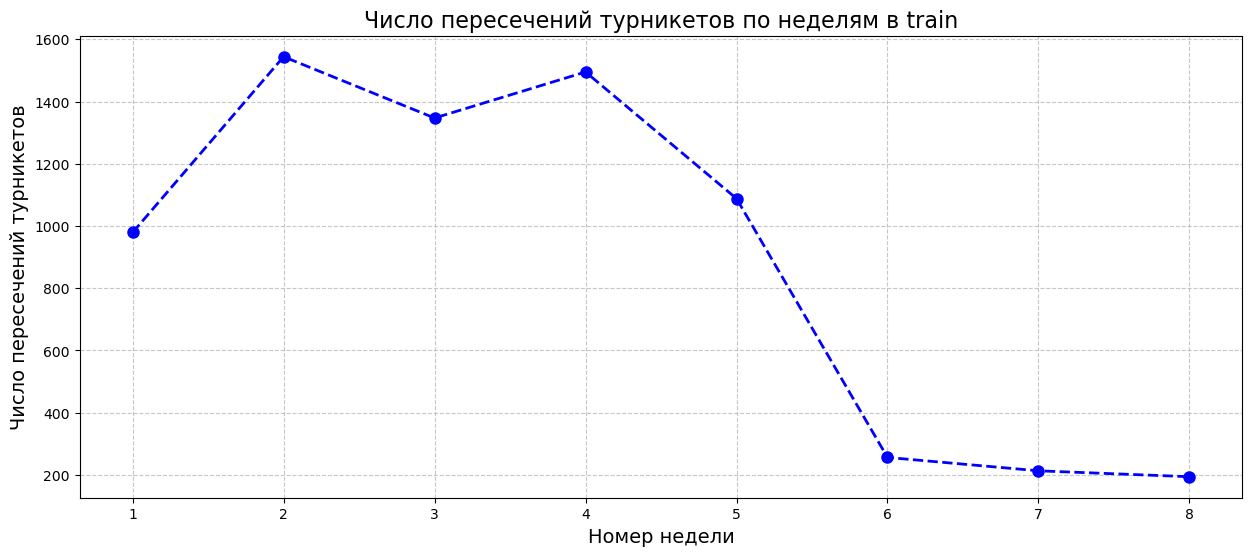

In [20]:
# Сортируем значения по номеру недели и строим график
plt.figure(figsize=(15, 6))
test['week_number'].value_counts().sort_index().plot(
    grid=True,
    color='blue',
    linestyle='dashed', 
    marker='o',
    markersize=8, 
    linewidth=2  
)
plt.title('Число пересечений турникетов по неделям в train', fontsize=16)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Число пересечений турникетов', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

количество посещений на 6, 7, 8 неделе на порядки ниже чем в предыдущие недели, такие данные будут вредны для модели машинного обучения

In [21]:
# удаление выбросов
test = test[~test['week_number'].isin([6, 7, 8])]

Так как признак week_number не пересекается в train и test, то удалим его, как и признак ts

In [22]:
# удаление признаков
train = train.drop(['ts', 'week_number'], axis = 1)
test = test.drop(['ts', 'week_number'], axis = 1)

In [23]:
# проверка и вывод недостающих hour
if sorted(list(train['hour'].unique())) != sorted(list(test['hour'].unique())):
    train_list = list(train['hour'].unique())
    test_list = list(test['hour'].unique())  
    print('Пропущенные hour', [x for x in train_list if x not in test_list] + [x for x in test_list if x not in train_list])
else:
    print('hour в train и test идентичны')

Пропущенные hour [6, 0, 1, 3]


Создадим признаки с учетом того, что у нас нет 6, 0, 1, 3 часа

In [24]:
# создание признаков 
night = [0, 1, 3, 22, 23]
morning = [6, 7, 8, 9, 10, 11]
time_day = [12, 13, 14, 15, 16, 17]
evening = [18, 19, 20, 21]
day_hours = [night, morning, time_day, evening]
day_hours_name = ['night', 'morning', 'time_day', 'evening']

for number, i in enumerate(day_hours):
    train[day_hours_name[number]] = train['hour'].apply(lambda row: 1 if row in i else 0)
    test[day_hours_name[number]] = test['hour'].apply(lambda row: 1 if row in i else 0)

In [25]:
# проверка и вывод недостающих day
if sorted(list(train['day'].unique())) != sorted(list(test['day'].unique())):
    train_list = list(train['day'].unique())
    test_list = list(test['day'].unique())  
    print('Пропущенные day', [x for x in train_list if x not in test_list] + [x for x in test_list if x not in train_list])
else:
    print('day в train и test идентичны')

Пропущенные day [8]


In [26]:
# создаем список уникальных значений дней
day_list = list(np.sort(train['day'].unique()))
day_list = [int(x) for x in day_list]

for i, day_value in enumerate(day_list):
    train[f'day_{i + 1}'] = train['day'].apply(lambda row: 1 if day_value == row else 0)
    test[f'day_{i + 1}'] = test['day'].apply(lambda row: 1 if day_value == row else 0)

In [27]:
# проверка и вывод недостающих weekday
if sorted(list(train['weekday'].unique())) != sorted(list(test['weekday'].unique())):
    train_list = list(train['weekday'].unique())
    test_list = list(test['weekday'].unique())  
    print('Пропущенные weekday', [x for x in train_list if x not in test_list] + [x for x in test_list if x not in train_list])
else:
    print('weekday в train и test идентичны')

weekday в train и test идентичны


In [28]:
# создаем новые признаки 
list_weekday = np.sort(train['weekday'].unique())
list_weekday = [int(x) for x in list_weekday]

for i, weekday_value in enumerate(list_weekday):
    train[f'weekday_{i}'] = train['weekday'].apply(lambda row: 1 if weekday_value == row else 0)
    test[f'weekday_{i}'] = test['weekday'].apply(lambda row: 1 if weekday_value == row else 0)

Ранее было выяснено что hour в train и test не совпадают, поэтому создадим единый список

In [29]:
# создание списка
list_hours_train = np.sort(train['hour'].unique())
list_hours_train = [int(x) for x in list_hours_train]
list_hours_test = np.sort(test['hour'].unique())
list_hours_test = [int(x) for x in list_hours_test]
common_list_hours = list(set(list_hours_train + list_hours_test))
common_list_hours = [int(x) for x in common_list_hours]
common_list_hours

[0, 1, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [30]:
# создание новых признаков 
for hour_value in common_list_hours:
    train[f'hour_{hour_value}'] = train['hour'].apply(lambda row: 1 if hour_value == row else 0)
    test[f'hour_{hour_value}'] = test['hour'].apply(lambda row: 1 if hour_value == row else 0)


In [31]:
# выведем уникальные значения gate_id из датасета train
gate_id_train = list(np.sort(train['gate_id'].unique()))
gate_id_test = list(np.sort(test['gate_id'].unique()))
common_gate_list = list(set(gate_id_train + gate_id_test))
common_gate_list = [int(x) for x in common_gate_list]

In [32]:
# создание новых признаков
for gate_value in common_gate_list:
    train[f'gate_id_{gate_value}'] = train['gate_id'].apply(lambda row: 1 if gate_value == row else 0)
    test[f'gate_id_{gate_value}'] = test['gate_id'].apply(lambda row: 1 if gate_value == row else 0)


На основе признака weekday создадим два бинарных признака: день может быть рабочим, день может быть выходным

In [33]:
# для каждого типа дня недели создадим соответствующий список
working_days = [0, 1, 2, 3, 4]
weekends = [5, 6]
week_days = [working_days, weekends]
week_days_name = ['working_days', 'weekends']

In [34]:
# создание новых признаков
number = 0
for weekdays_list in week_days:
    train[week_days_name[number]] = train['weekday'].apply(lambda row: 1 if row in weekdays_list else 0)
    test[week_days_name[number]] = test['weekday'].apply(lambda row: 1 if row in weekdays_list else 0)
    number += 1

In [35]:
# проверка и вывод недостающих minute
if sorted(list(train['minute'].unique())) != sorted(list(test['minute'].unique())):
    train_list = list(train['minute'].unique())
    test_list = list(test['minute'].unique())  
    print('Пропущенные weekday', [x for x in train_list if x not in test_list] + [x for x in test_list if x not in train_list])
else:
    print('minute в train и test идентичны')

minute в train и test идентичны


Сформируем 4 бинарных признака 

In [36]:
# для каждого периода создадим список значений минут
first_quarter = list(range(0, 15))
second_quarter = list(range(15, 30))
third_quarter = list(range(30, 45))
fourth_quarter = list(range(45, 60))
hour_minutes = [
    first_quarter, second_quarter,
    third_quarter, fourth_quarter
]
hour_minutes_names = [
    'first_quarter', 'second_quarter',
    'third_quarter', 'fourth_quarter'
]

In [37]:
# создание новых признаков
number = 0
for minutes_list in hour_minutes:
    train[hour_minutes_names[number]] = train['minute'].apply(lambda row: 1 if row in minutes_list else 0)
    test[hour_minutes_names[number]] = test['minute'].apply(lambda row: 1 if row in minutes_list else 0)
    number += 1

Проверим есть ли в данных нулевые признаки (признаки полностью заполненные 0)

In [38]:
# проверка на нулевой вектор в train
temp_train = pd.DataFrame(train.sum(), columns = ['sum_total'])
temp_train.loc[temp_train['sum_total'] == 0]

,sum_total
hour_0,0
hour_1,0
hour_3,0


In [39]:
# проверка на нулевой вектор в test
temp_test = pd.DataFrame(test.sum(), columns = ['sum_total'])
temp_test.loc[temp_test['sum_total'] == 0]

,sum_total
day_8,0
hour_6,0


In [40]:
# создадим список из названий признаков на удаление
columns_to_del = (
    list(temp_train.loc[temp_train['sum_total'] == 0].index) +
    list(temp_test.loc[temp_test['sum_total'] == 0].index)
)
columns_to_del

['hour_0', 'hour_1', 'hour_3', 'day_8', 'hour_6']

In [41]:
# удаление нулевых векторов
train = train.drop(columns_to_del, axis = 1)
test = test.drop(columns_to_del, axis = 1)

Напишем код, который указывает на мультиколинеарность признаков, порог будем считать 0.75 и -0.75

In [42]:
# выявление признаков
correlation_matrix = train.corr()
threshold = 0.8
correlation_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            correlation_value = correlation_matrix.iloc[i, j]
            correlation_pairs.append((feature_pair, correlation_value))

for pair, correlation_value in correlation_pairs:
    print(f"Пара признаков: {pair}, Корреляция: {correlation_value}")

Пара признаков: ('night', 'hour_22'), Корреляция: 0.8888494373250212
Пара признаков: ('weekday_5', 'working_days'), Корреляция: -0.842200156573852
Пара признаков: ('weekday_5', 'weekends'), Корреляция: 0.8422001565738518
Пара признаков: ('working_days', 'weekends'), Корреляция: -1.0000000000000002


In [43]:
# удалим признаки создающие мультиколинеарность
train = train.drop(columns = ['hour_22', 'weekday_5', 'weekends'], axis = 1)
test = test.drop(columns = ['hour_22', 'weekday_5', 'weekends'], axis = 1)

Выделим features и target

In [44]:
# выделение features и target
features_train = train.drop(columns = 'user_id')
target_train = train['user_id']
features_train.shape, target_train.shape

((37216, 79), (37216,))

In [45]:
# выделение user_word и features
user_word = test['user_word']
features_test = test.drop(columns = 'user_word')
features_test.shape, user_word.shape

((6453, 79), (6453,))

In [48]:
# создаем коппи датасетов
features_train_ovr = features_train.copy()
features_test_ovr = features_test.copy()
features_train_ovr.shape, features_test_ovr.shape

((37216, 79), (6453, 79))

In [49]:
# применим MinMaxScaler()
scaler_ovr = MinMaxScaler()
scaler_ovr.fit(features_train_ovr)
features_train_ovr = scaler_ovr.transform(features_train_ovr)
features_test_ovr = scaler_ovr.transform(features_test_ovr)
features_test_ovr = scaler_ovr.transform(features_test_ovr)

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [53]:
# инициализация модели
lm = OneVsRestClassifier(
    LogisticRegression(
        multi_class='ovr',
        solver='lbfgs',
        max_iter = 1000, 
        random_state = 12345))

In [55]:
# обучим модель
lm.fit(features_train_ovr, target_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                 multi_class='ovr',
                                                 random_state=12345))

In [57]:
# получим предсказания
preds_train_lm = lm.predict(features_train_ovr)

In [59]:
# выведем отчет об итогах обучения
print(classification_report(
    target_train,
    preds_train_lm
))

              precision    recall  f1-score   support

           0       0.07      0.02      0.03      1244
           1       0.22      0.29      0.25      1288
           2       0.21      0.10      0.14        39
           3       0.18      0.35      0.23       989
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        10
           6       0.16      0.07      0.09      1990
           7       0.33      0.45      0.38        49
           8       0.41      0.31      0.35        29
           9       0.12      0.13      0.13      1034
          10       0.17      0.12      0.14        17
          11       0.10      0.10      0.10      1279
          12       0.15      0.32      0.20      1937
          14       0.25      0.46      0.32       685
          15       0.18      0.19      0.18      1701
          17       0.25      0.35      0.29       661
          18       0.35      0.29      0.32      1566
          19       0.19    

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
# получим предсказания модели на тестовых обучающих признаках
preds = lm.predict(features_test_ovr)

In [63]:
# объединим зашифрованные имена посетителей и предсказания модели
submit = pd.DataFrame()

submit['user_word'] = user_word
submit['preds'] = preds

In [67]:
# частота встречаемости user_word
user_word_frequency = pd.DataFrame(
    data = submit['user_word'].value_counts(ascending = False)
)
user_word_frequency.columns = ['quantity']
user_word_frequency

,quantity
f1,694
loss,484
sigmoid,400
binary,355
epsilon,334
x,294
significant,281
collinear,273
independent,259
residual,228


In [77]:
# список с 50 и менее наблюдениями
less_than_51 = [
    user_word_frequency.index.values[i]
    for i in range(len(user_word_frequency['quantity']))
    if user_word_frequency['quantity'][i] < 51
]
less_than_51.sort()
less_than_51

['aucroc', 'blue', 'lasso', 'logistic', 'precision', 'regression', 'y']

In [78]:
# предсказанные уникальные user_id
submit['preds'].unique()

array([ 3, 15,  1, 34, 31,  0, 12,  8, 50, 42, 18,  9, 40, 54, 33, 20, 11,
       53, 49,  6, 48, 28, 55, 27, 47, 46, 25, 37, 29, 57, 22, 19, 32, 39,
       24, 26], dtype=int64)

In [79]:
# выведем количество уникальных user_id,
# содержащихся в предсказании модели
submit['preds'].nunique()

36

Скорей всего система ошиблась в детекции посетителя, поэтому для каждого user_id c меньше 50 наблюдениями preds: -999

In [80]:
# итоговые предсказания получим на основе самого частотного 'user_id'
submit_file = pd.DataFrame(
    submit.groupby('user_word')['preds'].agg(
        lambda x: x.value_counts().index[0])
    )

In [81]:
# заменяем на -999 
submit_file['new_preds'] = [
    -999 if submit_file.index.values[i] in less_than_51
    else submit_file['preds'][i]
    for i in range(len(submit_file['preds']))
]

In [82]:
# удаление столбца preds и меняем название столбца 
submit_file = submit_file.drop(columns = ['preds'])
submit_file.columns = ['preds']
submit_file

,preds
user_word,
aucroc,-999
binary,12
blue,-999
categorical,15
coefficient,3
collinear,15
distributed,34
epsilon,15
f1,18


In [83]:
#количество уникальных user_id в submit_file
submit_file['preds'].nunique()

6

In [84]:
submit_file.to_csv('answer.csv')

In [85]:
code = """
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
"""

file_path = 'requirements.txt'

with open(file_path, 'w') as file:
    file.write(code)

In [87]:
# теперь попробуем CatBoost
catboost = CatBoostClassifier(
    random_state = 12345,
    logging_level = 'Silent',
    loss_function = 'MultiClassOneVsAll'
)

In [92]:
# инициализация пайплайна
pipe_catboost = imb_pipeline([
    ('feature_select', SelectKBest(score_func = chi2)),
    ('catboost', catboost)
])

In [93]:
# список гиперпараметров пайплайна
pd.DataFrame(pipe_catboost.get_params().keys())

,0
0,memory
1,steps
2,verbose
3,feature_select
4,catboost
5,feature_select__k
6,feature_select__score_func
7,catboost__loss_function
8,catboost__logging_level
9,catboost__random_state


In [168]:
# словарь с гиперпараметрами
params_catboost = {
    'feature_select__k': [40, 50, 60, 70, 80],
#     'catboost__iterations': [300, 500],
#     'catboost__learning_rate': [0.01, 0.03, 0.05, 0.1],
#     'catboost__depth': [2, 4, 6],
#     'catboost__l2_leaf_reg': [1, 3, 5]
}

In [169]:
# объявляем объект RandomizedSearchCV
grid_catboost = GridSearchCV(
    pipe_catboost,
    params_catboost,
#     n_iter = 10,
    scoring = 'roc_auc',
    verbose = 1,
    cv = 3,
    refit = True,
    n_jobs = -1)

In [170]:
%%time
# обучение модели
grid_catboost.fit(features_train, target_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kil_a\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y

CPU times: total: 12min 58s
Wall time: 10min 14s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_select',
                                        SelectKBest(score_func=<function chi2 at 0x0000022032E1A200>)),
                                       ('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x0000022032D1AEC0>)]),
             n_jobs=-1, param_grid={'feature_select__k': [40, 50, 60, 70, 80]},
             scoring='roc_auc', verbose=1)

In [171]:
# сохранение лучшей модели
best_catboost = grid_catboost.best_estimator_
print(f'Гиперпараметры лучшей модели: {grid_catboost.best_params_}')

Гиперпараметры лучшей модели: {'feature_select__k': 40}


In [172]:
# получим предсказания
preds_train = best_catboost.predict(features_train)

In [173]:
# отчет об итогах обучения
print(classification_report(
    target_train,
    preds_train
))

              precision    recall  f1-score   support

           0       0.44      0.26      0.32      1244
           1       0.45      0.42      0.44      1288
           2       0.49      0.69      0.57        39
           3       0.45      0.58      0.51       989
           4       1.00      1.00      1.00         2
           5       0.44      0.40      0.42        10
           6       0.44      0.28      0.34      1990
           7       0.69      0.76      0.72        49
           8       0.53      0.93      0.67        29
           9       0.30      0.42      0.35      1034
          10       0.44      0.41      0.42        17
          11       0.30      0.27      0.28      1279
          12       0.33      0.55      0.42      1937
          14       0.45      0.76      0.57       685
          15       0.37      0.51      0.43      1701
          17       0.53      0.72      0.61       661
          18       0.57      0.49      0.53      1566
          19       0.45    

In [174]:
# предсказания на test
preds = best_catboost.predict(features_test)

In [175]:
# объединим зашифрованные имена посетителей и предсказания модели
submit = pd.DataFrame()

submit['user_word'] = user_word
submit['preds'] = preds

In [176]:
# уникальные предсказанные user_id
print(f'Уникальные user_id: {np.sort(submit.preds.unique())}')
print(f'Количество предсказанных уникальных user_id: {submit.preds.nunique()}')

Уникальные user_id: [ 0  1  3  6  9 11 12 14 15 17 19 23 24 25 26 29 30 32 33 35 37 39 41 43
 46 49 50 54 55]
Количество предсказанных уникальных user_id: 29


In [177]:
# итоговое предсказание получим на основе чаще предсказанного user_id
submit_file = pd.DataFrame(
    submit.groupby('user_word')['preds'].agg(
        lambda x: x.value_counts().index[0])
    )

In [178]:
# предсказания 
submit_file

,preds
user_word,
aucroc,55
binary,12
blue,55
categorical,14
coefficient,15
collinear,55
distributed,55
epsilon,1
f1,6


In [179]:
# количество уникальных user_id в submit_file
submit_file['preds'].nunique()

14

In [180]:
submit_file.to_csv('answer.csv')

In [181]:
code = """
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imb_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
"""

file_path = 'requirements.txt'

with open(file_path, 'w') as file:
    file.write(code)

In [126]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37216 entries, 0 to 37517
Data columns (total 79 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Unnamed: 0      37216 non-null  int64
 1   gate_id         37216 non-null  int64
 2   day             37216 non-null  int64
 3   weekday         37216 non-null  int64
 4   hour            37216 non-null  int64
 5   minute          37216 non-null  int64
 6   night           37216 non-null  int64
 7   morning         37216 non-null  int64
 8   time_day        37216 non-null  int64
 9   evening         37216 non-null  int64
 10  day_1           37216 non-null  int64
 11  day_2           37216 non-null  int64
 12  day_3           37216 non-null  int64
 13  day_4           37216 non-null  int64
 14  day_5           37216 non-null  int64
 15  day_6           37216 non-null  int64
 16  day_7           37216 non-null  int64
 17  day_9           37216 non-null  int64
 18  day_10          37216 non-

Можно добавить новые признаки такие как: время между проходами через конкретный турникет и время между каждой записью

In [348]:
def process_timestamp(df, timestamp_column='ts'):
    """
    Добавление новых признаков на основе признака 'ts'
    """
    df['date'] = df['ts'].dt.date # приведение к нормальному типу данных
    df['day'] = df[timestamp_column].dt.day # Извлечение дня месяца
    df['hour'] = df[timestamp_column].dt.hour # Извлечение часа
    df['minute'] = df[timestamp_column].dt.minute # Извлечение минут
    df['second'] = df[timestamp_column].dt.second # Извлечение секунд
    df['minutes'] = df['hour'] * 60 + df['minute'] # Расчет времени в минутах от начала дня
    df['seconds'] = df['minutes'] * 60 + df['second'] # Расчет времени в секундах от начала дня
    df['week'] = df[timestamp_column].dt.isocalendar().week # Извлечение номера недели
    df['month'] = df[timestamp_column].dt.month # Извлечение номера месяца
    df['weekday'] = df[timestamp_column].dt.weekday + 1 # Извлечение дня недели (1-понедельник, ..., 7-воскресенье)
train['ts'] = pd.to_datetime(train['ts'])
test['ts'] = pd.to_datetime(test['ts'])
process_timestamp(train)
process_timestamp(test)

In [349]:
train, test = train.drop('Unnamed: 0', axis = 1), test.drop('Unnamed: 0', axis = 1)

Посмотрим на наши данные с новыми признаками

In [350]:
print(train.info())
print(train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37518 entries, 0 to 37517
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  37518 non-null  int64         
 1   ts       37518 non-null  datetime64[ns]
 2   gate_id  37518 non-null  int64         
 3   date     37518 non-null  object        
 4   day      37518 non-null  int64         
 5   hour     37518 non-null  int64         
 6   minute   37518 non-null  int64         
 7   second   37518 non-null  int64         
 8   minutes  37518 non-null  int64         
 9   seconds  37518 non-null  int64         
 10  week     37518 non-null  UInt32        
 11  month    37518 non-null  int64         
 12  weekday  37518 non-null  int64         
dtypes: UInt32(1), datetime64[ns](1), int64(10), object(1)
memory usage: 3.6+ MB
None
(37518, 13)


In [351]:
print(test.info())
print(test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7125 entries, 0 to 7124
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         7125 non-null   datetime64[ns]
 1   gate_id    7125 non-null   int64         
 2   user_word  7125 non-null   object        
 3   date       7125 non-null   object        
 4   day        7125 non-null   int64         
 5   hour       7125 non-null   int64         
 6   minute     7125 non-null   int64         
 7   second     7125 non-null   int64         
 8   minutes    7125 non-null   int64         
 9   seconds    7125 non-null   int64         
 10  week       7125 non-null   UInt32        
 11  month      7125 non-null   int64         
 12  weekday    7125 non-null   int64         
dtypes: UInt32(1), datetime64[ns](1), int64(9), object(2)
memory usage: 702.9+ KB
None
(7125, 13)


In [352]:
train

,user_id,ts,gate_id,date,day,hour,minute,second,minutes,seconds,week,month,weekday
0,18,2022-07-29 09:08:54,7,2022-07-29,29,9,8,54,548,32934,30,7,5
1,18,2022-07-29 09:09:54,9,2022-07-29,29,9,9,54,549,32994,30,7,5
2,18,2022-07-29 09:09:54,9,2022-07-29,29,9,9,54,549,32994,30,7,5
3,18,2022-07-29 09:10:06,5,2022-07-29,29,9,10,6,550,33006,30,7,5
4,18,2022-07-29 09:10:08,5,2022-07-29,29,9,10,8,550,33008,30,7,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37513,6,2022-12-31 20:38:56,11,2022-12-31,31,20,38,56,1238,74336,52,12,6
37514,6,2022-12-31 20:39:22,6,2022-12-31,31,20,39,22,1239,74362,52,12,6
37515,6,2022-12-31 20:39:23,6,2022-12-31,31,20,39,23,1239,74363,52,12,6
37516,6,2022-12-31 20:39:31,9,2022-12-31,31,20,39,31,1239,74371,52,12,6


In [353]:
test

,ts,gate_id,user_word,date,day,hour,minute,second,minutes,seconds,week,month,weekday
0,2023-01-03 08:21:00,9,gini,2023-01-03,3,8,21,0,501,30060,1,1,2
1,2023-01-03 08:21:00,9,gini,2023-01-03,3,8,21,0,501,30060,1,1,2
2,2023-01-03 08:21:18,5,gini,2023-01-03,3,8,21,18,501,30078,1,1,2
3,2023-01-03 08:21:19,5,gini,2023-01-03,3,8,21,19,501,30079,1,1,2
4,2023-01-03 08:21:39,10,gini,2023-01-03,3,8,21,39,501,30099,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7120,2023-02-24 19:43:36,11,collinear,2023-02-24,24,19,43,36,1183,71016,8,2,5
7121,2023-02-24 19:44:00,4,collinear,2023-02-24,24,19,44,0,1184,71040,8,2,5
7122,2023-02-24 19:44:01,4,collinear,2023-02-24,24,19,44,1,1184,71041,8,2,5
7123,2023-02-24 19:44:09,9,collinear,2023-02-24,24,19,44,9,1184,71049,8,2,5


Выделим из test признак к которму будем делать предсказания

In [354]:
test_user_word = pd.DataFrame(test.user_word)
test = test.drop('user_word', axis = 1)

Распределение по date в train

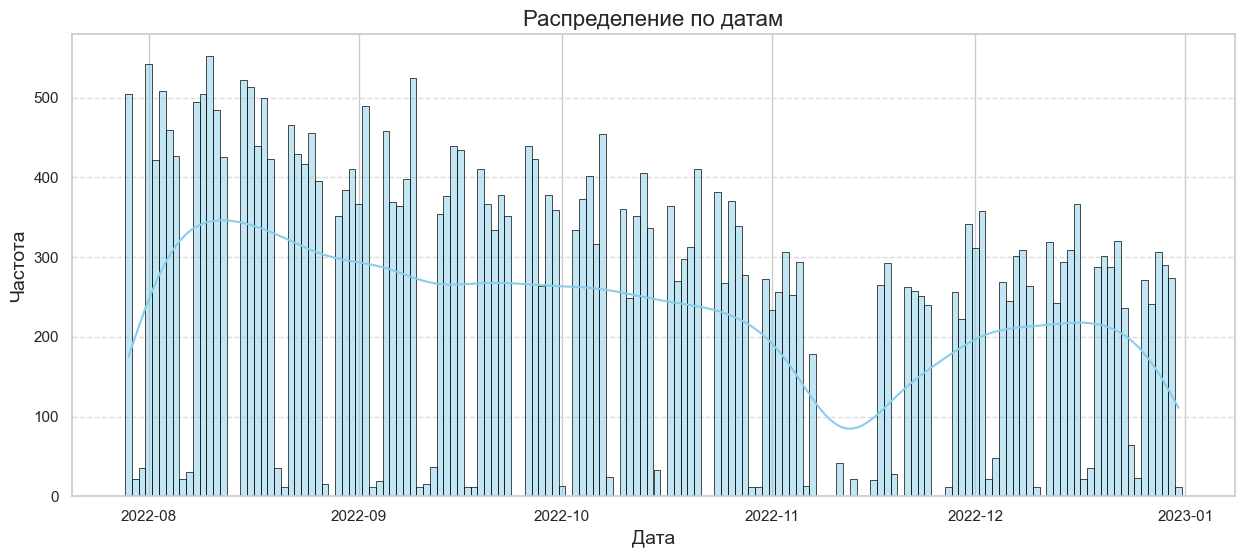

In [355]:
sns.set(style  ="whitegrid", palette = "pastel")
plt.figure(figsize = (15, 6))
ax = sns.histplot(data = train['date'], kde = True, bins = train['date'].nunique(), color = "skyblue", edgecolor = "black")
plt.title("Распределение по датам", fontsize = 16)
plt.xlabel("Дата", fontsize = 14)
plt.ylabel("Частота", fontsize = 14)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

Распределение по minutes в train

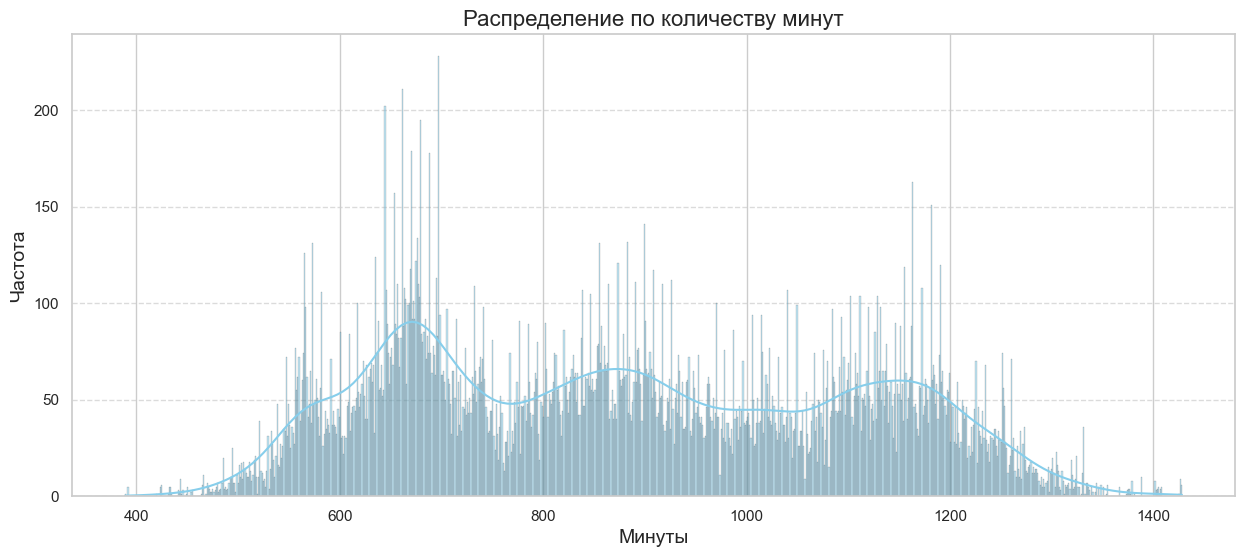

In [356]:
sns.set(style = "whitegrid", palette = "pastel")
plt.figure(figsize = (15, 6))
ax = sns.histplot(data = train['minutes'], kde = True, bins = train['minutes'].nunique(), color = "skyblue", edgecolor = "black")
plt.title("Распределение по количеству минут", fontsize = 16)
plt.xlabel("Минуты", fontsize = 14)
plt.ylabel("Частота", fontsize = 14)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

Распределение по date в test

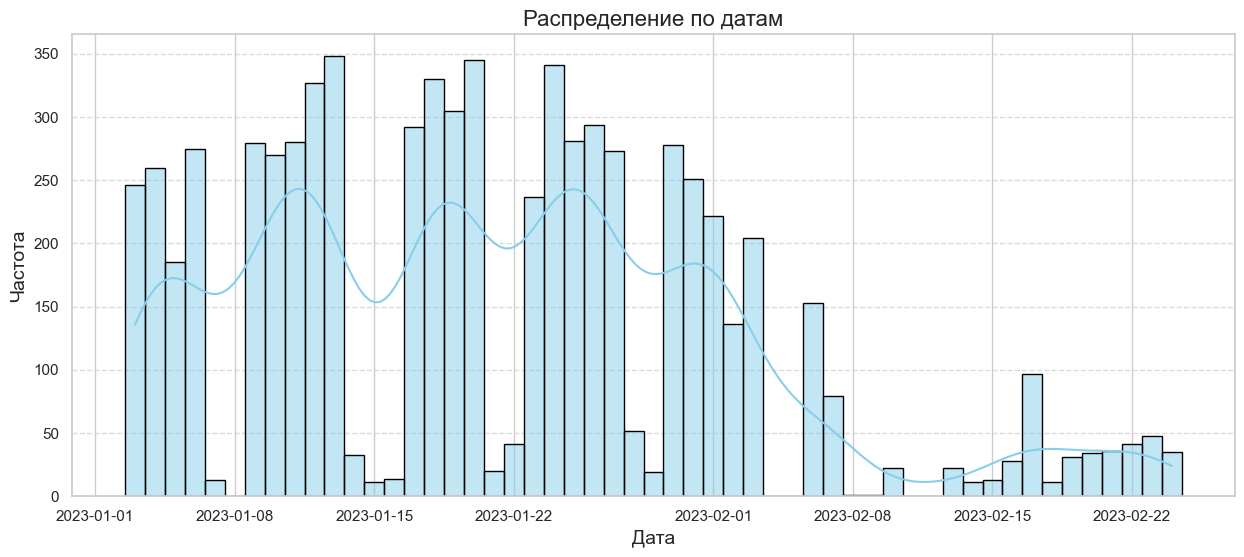

In [357]:
sns.set(style = "whitegrid", palette = "pastel")
plt.figure(figsize = (15, 6))
ax = sns.histplot(data = test['date'], kde = True, bins =test['date'].nunique(), color = "skyblue", edgecolor = "black")
plt.title("Распределение по датам", fontsize = 16)
plt.xlabel("Дата", fontsize = 14)
plt.ylabel("Частота", fontsize = 14)
plt.grid(axis='y', linestyle='--', alpha = 0.7)
plt.show()

Распределение по minutes в test

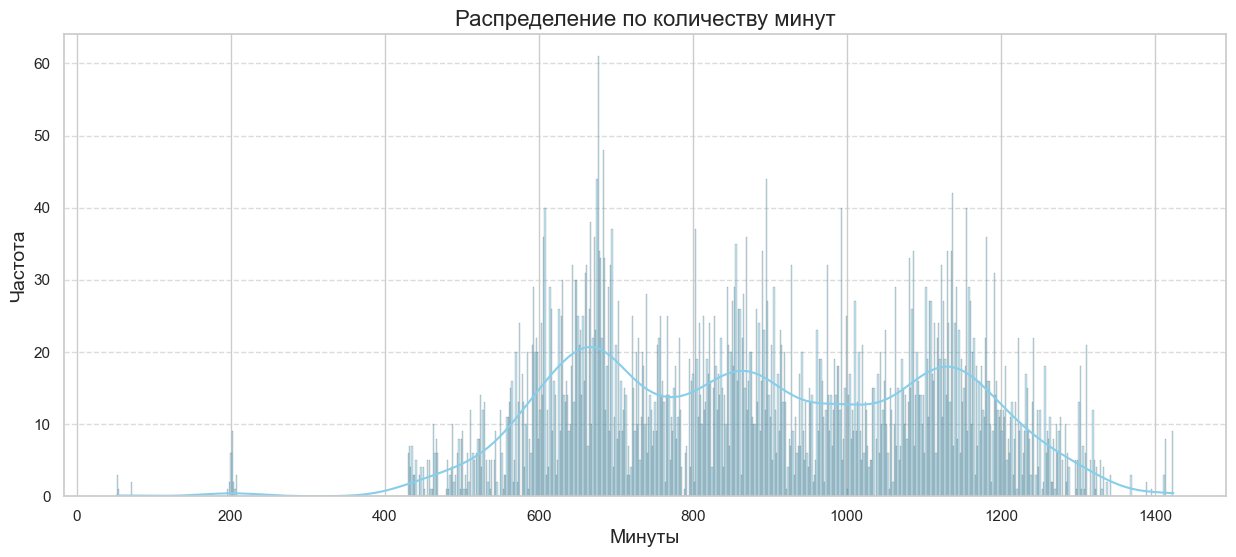

In [358]:
sns.set(style = "whitegrid", palette = "pastel")
plt.figure(figsize = (15, 6))
ax = sns.histplot(data = test['minutes'], kde = True, bins = test['minutes'].nunique(), color = "skyblue", edgecolor = "black")
plt.title("Распределение по количеству минут", fontsize = 16)
plt.xlabel("Минуты", fontsize = 14)
plt.ylabel("Частота", fontsize = 14)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

Выполним агрегацию по признаку user_id

In [359]:
def aggregate_user_data(df):
    """
    Агрегация данных по пользователям, включая количество записей,
    количество уникальных дат, минимальную и максимальную дату.
    Результаты сортируются по количеству записей в возрастающем порядке.
    """
    grp_user = df.groupby('user_id', as_index=False).agg(
        counts=('ts', 'count'),
        date_unique=('date', lambda x: x.nunique()),
        date_min=('date', 'min'),
        date_max=('date', 'max')
    )
    grp_user.sort_values('counts', inplace=True)
    
    return grp_user
aggregate_user_data(train)

,user_id,counts,date_unique,date_min,date_max
4,4,2,1,2022-08-09,2022-08-09
49,51,3,2,2022-12-13,2022-12-16
42,44,4,1,2022-12-28,2022-12-28
50,52,5,1,2022-08-10,2022-08-10
19,21,5,2,2022-12-16,2022-12-28
5,5,10,2,2022-10-26,2022-11-30
28,30,10,2,2022-12-16,2022-12-27
36,38,13,2,2022-11-01,2022-11-03
10,10,17,2,2022-11-30,2022-12-07
8,8,29,2,2022-08-09,2022-11-03


Пользователи которые редко бывали 

In [360]:
n_df = aggregate_user_data(train)
print(n_df[(n_df['counts'] < 3) | (n_df['date_unique'] < 2)])
print('\n--------------------------------------------------------\n')
print('Выбросы в user_id:', list(n_df[(n_df['counts'] < 3) | (n_df['date_unique'] < 2)].user_id.unique()))

    user_id  counts  date_unique    date_min    date_max
4         4       2            1  2022-08-09  2022-08-09
42       44       4            1  2022-12-28  2022-12-28
50       52       5            1  2022-08-10  2022-08-10

--------------------------------------------------------

Выбросы в user_id: [4, 44, 52]


Проверим все ли турникеты в trian присутствуют в test

In [361]:
list_train_gate = train.gate_id.unique()
for i in list_train_gate:
    if i not in test.gate_id.unique():
        print(f'Не нашлось турникета: {i}')

Не нашлось турникета: 0
Не нашлось турникета: 16


Теперь у нас есть записи, которые будут считаться выбросами. 

In [362]:
mask = train.user_id.isin([4,51]) | train.gate_id.isin([0,16]) 
train[mask]

,user_id,ts,gate_id,date,day,hour,minute,second,minutes,seconds,week,month,weekday
3504,4,2022-08-09 10:09:08,8,2022-08-09,9,10,9,8,609,36548,32,8,2
3505,4,2022-08-09 10:09:08,8,2022-08-09,9,10,9,8,609,36548,32,8,2
12652,25,2022-09-06 11:16:28,0,2022-09-06,6,11,16,28,676,40588,36,9,2
12653,25,2022-09-06 11:16:36,0,2022-09-06,6,11,16,36,676,40596,36,9,2
21309,25,2022-10-07 16:44:37,16,2022-10-07,7,16,44,37,1004,60277,40,10,5
21310,25,2022-10-07 16:44:38,16,2022-10-07,7,16,44,38,1004,60278,40,10,5
33465,51,2022-12-13 13:30:11,3,2022-12-13,13,13,30,11,810,48611,50,12,2
34330,51,2022-12-16 13:56:08,9,2022-12-16,16,13,56,8,836,50168,50,12,5
34331,51,2022-12-16 13:56:08,9,2022-12-16,16,13,56,8,836,50168,50,12,5
36798,56,2022-12-28 14:49:51,16,2022-12-28,28,14,49,51,889,53391,52,12,3


In [363]:
train = train[~((train['user_id'].isin([4,44,52])) & (train['gate_id'].isin([0,16])))]

Напишем функцию для добавления в train и test новый признак, который будет отвечать за подсчет количества срабатываний за день и колличество срабатываний для каждого gate_id

In [364]:
def add_count_columns(df):
    """
    Функция добавления новых признаков
    """
    df['trigg_count'] = df.groupby('date')['ts'].transform('count') # количество записей для каждой уникальной даты
    df['trig_count_by_id'] = df.groupby(['date', 'gate_id'])['ts'].transform('count') # количеством записей для каждого gate_id
add_count_columns(train)
add_count_columns(test)

Еще раз проверим пропуски в данных

In [365]:
checklist = ['test', 'train']
for name in checklist:
    pass_value_barh(name)

пропусков не осталось 
пропусков не осталось 


In [366]:
train_0 = train.copy()
test_0 = test.copy()

In [367]:
train = train.drop(['ts', 'date'], axis=1, errors='ignore')
train['week'] = train['week'].astype('int64')
test = test.drop(['ts', 'date'], axis=1, errors='ignore')
test['week'] = test['week'].astype('int64')

Масштабирование данных и выделение target и features

In [368]:
features_train = train.drop('user_id', axis = 1)
features_test = test
target_train = train['user_id']

In [369]:
scaler = StandardScaler()

In [370]:
features_train = pd.DataFrame(scaler.fit_transform(features_train), columns = features_train.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns = features_test.columns)

Подбор модели, подбор гиперпараметров и обучение модели 

%%time
param_grid = {
    'iterations': [200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
}

model_cat = CatBoostClassifier(loss_function='MultiClass', 
                               eval_metric='TotalF1',
                               random_seed=12345)

grid_model_cat = GridSearchCV(estimator=model_cat,
                              param_grid=param_grid,
                              cv=3,
                              scoring='accuracy')

grid_model_cat.fit(features_train, target_train)

best_params = grid_model_cat.best_params_
print("Лучшие параметры:", best_params)

best_accuracy = grid_model_cat.best_score_
print("Точность лучшей модели:", best_accuracy)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

model_rf = RandomForestClassifier(random_state=12345)

grid_model_rf = GridSearchCV(estimator=model_rf,
                             param_grid=param_grid_rf,
                             cv=3,
                             scoring='accuracy')

grid_model_rf.fit(features_train, target_train)

best_params_rf = grid_model_rf.best_params_
print("Лучшие параметры для RandomForest:", best_params_rf)

best_accuracy_rf = grid_model_rf.best_score_
print("Точность лучшей модели RandomForest:", best_accuracy_rf)


param_grid_knn_extended = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
}

model_knn_extended = KNeighborsClassifier()

grid_model_knn_extended = GridSearchCV(estimator=model_knn_extended,
                                       param_grid=param_grid_knn_extended,
                                       cv=3,
                                       scoring='accuracy')

grid_model_knn_extended.fit(features_train, target_train)

best_params_knn_extended = grid_model_knn_extended.best_params_
print("Лучшие параметры для KNeighborsClassifier:", best_params_knn_extended)

best_accuracy_knn_extended = grid_model_knn_extended.best_score_
print("Точность лучшей модели KNeighborsClassifier:", best_accuracy_knn_extended)


Моели выдают очень плохой реульат, нужно добавить еще признаков и найти паттерны

In [371]:
train_0['day_period'] = pd.cut(train_0['hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], right=False)
train_0['visits_per_day_period'] = train_0.groupby(['user_id', 'day_period'])['ts'].transform('count')
train_0['is_weekend'] = (train_0['weekday'] >= 6).astype(int)
train_0['visit_duration'] = train_0.groupby('user_id')['ts'].transform(lambda x: (x.max() - x.min()).total_seconds())
train_0['mean_time_between_visits'] = train_0.groupby('user_id')['ts'].transform(lambda x: x.diff().mean().total_seconds())
train_0['visits_per_month'] = train_0.groupby(['user_id', 'month'])['ts'].transform('count')
train_0['mean_visits_per_day'] = train_0.groupby(['user_id', 'date'])['ts'].transform('count').groupby(train_0['user_id']).transform('mean')
for hour in range(24):
    train_0[f'hour_{hour}_visit'] = (train_0['hour'] == hour).astype(int)

In [372]:
test_0 = pd.merge(test_0, test_user_word, left_index=True, right_index=True)

In [373]:
def second_process_data(df, id_column='user_id'):
    df['day_period'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], right=False)
    df['visits_per_day_period'] = df.groupby([id_column, 'day_period'])['ts'].transform('count')
    df['is_weekend'] = (df['weekday'] >= 6).astype(int)
    df['visit_duration'] = df.groupby(id_column)['ts'].transform(lambda x: (x.max() - x.min()).total_seconds())
    df['mean_time_between_visits'] = df.groupby(id_column)['ts'].transform(lambda x: x.diff().mean().total_seconds())
    df['visits_per_month'] = df.groupby([id_column, 'month'])['ts'].transform('count')
    df['mean_visits_per_day'] = df.groupby([id_column, 'date'])['ts'].transform('count').groupby(df[id_column]).transform('mean')
    for hour in range(24):
        df[f'hour_{hour}_visit'] = (df['hour'] == hour).astype(int)

second_process_data(train_0, id_column='user_id')

second_process_data(test_0, id_column='user_word')

In [374]:
def process_turnstile_patterns(df, timestamp_column='ts'):
    """
    Добавление признаков на основе паттернов прохода через турникет
    """
    df['turnstile_pattern'] = df['date'].astype(str) + '_' + df['hour'].astype(str) + '_' + df['minute'].astype(str)
    df['turnstile_passage_rank'] = df.groupby('turnstile_pattern').cumcount() + 1
    # пропуски заполняются 0 так как можем предполагать, что у пользователя нет предыдущего прохода
    df['time_since_last_turnstile'] = df.groupby('turnstile_pattern')[timestamp_column].diff().dt.total_seconds()
    df['time_since_last_turnstile'] = df['time_since_last_turnstile'].fillna(0)  
    df['mean_time_between_turnstile'] = df.groupby('turnstile_pattern')['time_since_last_turnstile'].transform('mean')
    df['mean_time_between_turnstile'] = df['mean_time_between_turnstile'].fillna(0)  
    df['std_time_between_turnstile'] = df.groupby('turnstile_pattern')['time_since_last_turnstile'].transform('std')
    df['std_time_between_turnstile'] = df['std_time_between_turnstile'].fillna(0)  
process_turnstile_patterns(train_0)
process_turnstile_patterns(test_0)

In [375]:
test_user_word = pd.DataFrame(test_0.user_word)
test_0 = test_0.drop('user_word', axis = 1)

In [376]:
train_0 = train_0.drop(['ts', 'date'], axis=1, errors='ignore')
train_0['week'] = train_0['week'].astype('int64')
test_0 = test_0.drop(['ts', 'date'], axis=1, errors='ignore')
test_0['week'] = test_0['week'].astype('int64')

In [377]:
features_train = train_0.drop('user_id', axis = 1)
features_test = test_0
target_train = train_0['user_id']

In [378]:
le = LabelEncoder()
day_period_mapping = {'night': 0, 'morning': 1, 'afternoon': 2, 'evening': 3}

features_train['day_period'] = features_train['day_period'].astype(str)
features_test['day_period'] = features_test['day_period'].astype(str)
features_train['day_period'] = features_train['day_period'].map(day_period_mapping)
features_test['day_period'] = features_test['day_period'].map(day_period_mapping)

features_train['day_period'] = features_train['day_period'].astype(float)
features_test['day_period'] = features_test['day_period'].astype(float)

combined_data = pd.concat([features_train['day_period'], features_test['day_period']], axis=0)
combined_data_encoded = le.fit_transform(combined_data)

features_train['day_period'] = le.transform(features_train['day_period'])
features_test['day_period'] = le.transform(features_test['day_period'])

In [379]:
features_train = features_train.drop('turnstile_pattern', axis = 1)
features_test = features_test.drop('turnstile_pattern', axis = 1)

In [380]:
numeric_columns = [col for col in features_train.columns]
scaler = StandardScaler()
features_train[numeric_columns] = scaler.fit_transform(features_train[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

In [383]:
%%time
param_grid = {
    'iterations': [300],
    'learning_rate': [0.05, 0.1], 
    'depth': [2, 4]
}

model_cat = CatBoostClassifier()

grid_model_cat = GridSearchCV(estimator=model_cat,
                              param_grid=param_grid,
                              cv=2,
                              scoring='roc_auc')

grid_model_cat.fit(features_train, target_train)

best_params_cat = grid_model_cat.best_params_
print("Лучшие параметры:", best_params_cat)

best_accuracy = grid_model_cat.best_score_
print("Точность лучшей модели:", best_accuracy)

0:	learn: 3.7254633	total: 33.4ms	remaining: 10s
1:	learn: 3.4855524	total: 60.8ms	remaining: 9.05s
2:	learn: 3.3224109	total: 91ms	remaining: 9.01s
3:	learn: 3.2562067	total: 118ms	remaining: 8.74s
4:	learn: 3.1743737	total: 146ms	remaining: 8.6s
5:	learn: 3.0994322	total: 175ms	remaining: 8.57s
6:	learn: 2.9732196	total: 205ms	remaining: 8.57s
7:	learn: 2.8464822	total: 235ms	remaining: 8.57s
8:	learn: 2.7880422	total: 265ms	remaining: 8.55s
9:	learn: 2.6724291	total: 293ms	remaining: 8.51s
10:	learn: 2.6339303	total: 323ms	remaining: 8.49s
11:	learn: 2.5520762	total: 356ms	remaining: 8.54s
12:	learn: 2.4434209	total: 388ms	remaining: 8.56s
13:	learn: 2.3382775	total: 417ms	remaining: 8.52s
14:	learn: 2.2699410	total: 447ms	remaining: 8.5s
15:	learn: 2.1681132	total: 480ms	remaining: 8.52s
16:	learn: 2.1052644	total: 512ms	remaining: 8.52s
17:	learn: 2.0478212	total: 541ms	remaining: 8.47s
18:	learn: 2.0048480	total: 572ms	remaining: 8.46s
19:	learn: 1.9348928	total: 600ms	remaining:

168:	learn: 0.2316486	total: 5.04s	remaining: 3.91s
169:	learn: 0.2278523	total: 5.07s	remaining: 3.88s
170:	learn: 0.2269415	total: 5.1s	remaining: 3.84s
171:	learn: 0.2252376	total: 5.12s	remaining: 3.81s
172:	learn: 0.2226057	total: 5.15s	remaining: 3.78s
173:	learn: 0.2203206	total: 5.18s	remaining: 3.75s
174:	learn: 0.2198510	total: 5.2s	remaining: 3.72s
175:	learn: 0.2194529	total: 5.23s	remaining: 3.68s
176:	learn: 0.2187882	total: 5.25s	remaining: 3.65s
177:	learn: 0.2160908	total: 5.29s	remaining: 3.62s
178:	learn: 0.2144917	total: 5.31s	remaining: 3.59s
179:	learn: 0.2139883	total: 5.33s	remaining: 3.56s
180:	learn: 0.2137747	total: 5.36s	remaining: 3.52s
181:	learn: 0.2130658	total: 5.38s	remaining: 3.49s
182:	learn: 0.2108144	total: 5.42s	remaining: 3.46s
183:	learn: 0.2100579	total: 5.44s	remaining: 3.43s
184:	learn: 0.2095277	total: 5.46s	remaining: 3.4s
185:	learn: 0.2077137	total: 5.49s	remaining: 3.37s
186:	learn: 0.2059889	total: 5.52s	remaining: 3.33s
187:	learn: 0.2

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 367, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


3:	learn: 3.2456821	total: 118ms	remaining: 8.72s
4:	learn: 3.0804783	total: 148ms	remaining: 8.76s
5:	learn: 2.9613792	total: 177ms	remaining: 8.69s
6:	learn: 2.8800940	total: 206ms	remaining: 8.64s
7:	learn: 2.8125517	total: 232ms	remaining: 8.48s
8:	learn: 2.7226626	total: 262ms	remaining: 8.46s
9:	learn: 2.6127777	total: 291ms	remaining: 8.44s
10:	learn: 2.4940835	total: 323ms	remaining: 8.49s
11:	learn: 2.4229189	total: 354ms	remaining: 8.49s
12:	learn: 2.3472024	total: 384ms	remaining: 8.48s
13:	learn: 2.2630337	total: 417ms	remaining: 8.51s
14:	learn: 2.1874034	total: 447ms	remaining: 8.5s
15:	learn: 2.1188478	total: 480ms	remaining: 8.52s
16:	learn: 2.0399986	total: 517ms	remaining: 8.61s
17:	learn: 1.9959334	total: 553ms	remaining: 8.66s
18:	learn: 1.9438216	total: 580ms	remaining: 8.58s
19:	learn: 1.8805583	total: 610ms	remaining: 8.54s
20:	learn: 1.8172601	total: 638ms	remaining: 8.47s
21:	learn: 1.7745617	total: 664ms	remaining: 8.39s
22:	learn: 1.7521461	total: 690ms	remai

166:	learn: 0.2336085	total: 4.67s	remaining: 3.72s
167:	learn: 0.2316556	total: 4.69s	remaining: 3.69s
168:	learn: 0.2290941	total: 4.72s	remaining: 3.66s
169:	learn: 0.2264483	total: 4.75s	remaining: 3.63s
170:	learn: 0.2252450	total: 4.77s	remaining: 3.6s
171:	learn: 0.2232182	total: 4.8s	remaining: 3.57s
172:	learn: 0.2205157	total: 4.83s	remaining: 3.54s
173:	learn: 0.2187285	total: 4.85s	remaining: 3.51s
174:	learn: 0.2171551	total: 4.88s	remaining: 3.48s
175:	learn: 0.2139391	total: 4.91s	remaining: 3.46s
176:	learn: 0.2134831	total: 4.93s	remaining: 3.43s
177:	learn: 0.2129822	total: 4.96s	remaining: 3.4s
178:	learn: 0.2109274	total: 4.99s	remaining: 3.37s
179:	learn: 0.2102826	total: 5.01s	remaining: 3.34s
180:	learn: 0.2077534	total: 5.04s	remaining: 3.31s
181:	learn: 0.2052548	total: 5.07s	remaining: 3.29s
182:	learn: 0.2047290	total: 5.09s	remaining: 3.26s
183:	learn: 0.2032325	total: 5.12s	remaining: 3.23s
184:	learn: 0.2012461	total: 5.15s	remaining: 3.2s
185:	learn: 0.19

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 367, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 3.5228254	total: 31ms	remaining: 9.26s
1:	learn: 3.1191321	total: 59.9ms	remaining: 8.92s
2:	learn: 2.8144271	total: 92ms	remaining: 9.1s
3:	learn: 2.6006345	total: 124ms	remaining: 9.19s
4:	learn: 2.3460981	total: 152ms	remaining: 8.98s
5:	learn: 2.1684442	total: 184ms	remaining: 8.99s
6:	learn: 2.0002439	total: 213ms	remaining: 8.92s
7:	learn: 1.8615234	total: 243ms	remaining: 8.88s
8:	learn: 1.7278905	total: 274ms	remaining: 8.85s
9:	learn: 1.6394951	total: 303ms	remaining: 8.78s
10:	learn: 1.5946875	total: 332ms	remaining: 8.71s
11:	learn: 1.4884057	total: 360ms	remaining: 8.63s
12:	learn: 1.4033463	total: 391ms	remaining: 8.63s
13:	learn: 1.3313428	total: 421ms	remaining: 8.6s
14:	learn: 1.2814951	total: 450ms	remaining: 8.55s
15:	learn: 1.2283827	total: 481ms	remaining: 8.54s
16:	learn: 1.1684265	total: 512ms	remaining: 8.52s
17:	learn: 1.1226014	total: 542ms	remaining: 8.49s
18:	learn: 1.0693538	total: 571ms	remaining: 8.45s
19:	learn: 1.0307251	total: 599ms	remaining:

166:	learn: 0.1011843	total: 4.7s	remaining: 3.75s
167:	learn: 0.1010792	total: 4.73s	remaining: 3.72s
168:	learn: 0.1007010	total: 4.76s	remaining: 3.69s
169:	learn: 0.0993528	total: 4.79s	remaining: 3.66s
170:	learn: 0.0993286	total: 4.82s	remaining: 3.63s
171:	learn: 0.0992786	total: 4.84s	remaining: 3.61s
172:	learn: 0.0978376	total: 4.88s	remaining: 3.58s
173:	learn: 0.0962107	total: 4.9s	remaining: 3.55s
174:	learn: 0.0961875	total: 4.93s	remaining: 3.52s
175:	learn: 0.0950539	total: 4.96s	remaining: 3.49s
176:	learn: 0.0950209	total: 4.98s	remaining: 3.46s
177:	learn: 0.0934973	total: 5s	remaining: 3.43s
178:	learn: 0.0917956	total: 5.03s	remaining: 3.4s
179:	learn: 0.0917785	total: 5.06s	remaining: 3.37s
180:	learn: 0.0916810	total: 5.08s	remaining: 3.34s
181:	learn: 0.0915970	total: 5.1s	remaining: 3.31s
182:	learn: 0.0911057	total: 5.13s	remaining: 3.28s
183:	learn: 0.0906279	total: 5.16s	remaining: 3.25s
184:	learn: 0.0906016	total: 5.18s	remaining: 3.22s
185:	learn: 0.09058

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 367, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


4:	learn: 2.3065543	total: 158ms	remaining: 9.34s
5:	learn: 2.1421589	total: 199ms	remaining: 9.73s
6:	learn: 1.9720399	total: 233ms	remaining: 9.76s
7:	learn: 1.8533725	total: 267ms	remaining: 9.73s
8:	learn: 1.7619440	total: 300ms	remaining: 9.7s
9:	learn: 1.6332929	total: 331ms	remaining: 9.59s
10:	learn: 1.5134942	total: 359ms	remaining: 9.44s
11:	learn: 1.4273755	total: 388ms	remaining: 9.32s
12:	learn: 1.3615049	total: 419ms	remaining: 9.24s
13:	learn: 1.2906013	total: 448ms	remaining: 9.16s
14:	learn: 1.2184958	total: 477ms	remaining: 9.06s
15:	learn: 1.1606265	total: 504ms	remaining: 8.95s
16:	learn: 1.1172201	total: 530ms	remaining: 8.83s
17:	learn: 1.0639338	total: 560ms	remaining: 8.77s
18:	learn: 1.0257528	total: 585ms	remaining: 8.65s
19:	learn: 0.9913626	total: 616ms	remaining: 8.63s
20:	learn: 0.9409625	total: 643ms	remaining: 8.54s
21:	learn: 0.9095142	total: 669ms	remaining: 8.46s
22:	learn: 0.8922451	total: 695ms	remaining: 8.37s
23:	learn: 0.8588463	total: 721ms	rema

165:	learn: 0.0932874	total: 4.74s	remaining: 3.83s
166:	learn: 0.0920745	total: 4.77s	remaining: 3.8s
167:	learn: 0.0911247	total: 4.8s	remaining: 3.77s
168:	learn: 0.0911040	total: 4.82s	remaining: 3.74s
169:	learn: 0.0910932	total: 4.84s	remaining: 3.71s
170:	learn: 0.0892188	total: 4.88s	remaining: 3.68s
171:	learn: 0.0868281	total: 4.91s	remaining: 3.65s
172:	learn: 0.0860560	total: 4.94s	remaining: 3.62s
173:	learn: 0.0860168	total: 4.96s	remaining: 3.59s
174:	learn: 0.0852917	total: 4.99s	remaining: 3.56s
175:	learn: 0.0852200	total: 5.01s	remaining: 3.53s
176:	learn: 0.0852060	total: 5.04s	remaining: 3.5s
177:	learn: 0.0851885	total: 5.07s	remaining: 3.47s
178:	learn: 0.0851820	total: 5.09s	remaining: 3.44s
179:	learn: 0.0851700	total: 5.11s	remaining: 3.41s
180:	learn: 0.0851584	total: 5.14s	remaining: 3.38s
181:	learn: 0.0851473	total: 5.18s	remaining: 3.36s
182:	learn: 0.0837218	total: 5.21s	remaining: 3.33s
183:	learn: 0.0824688	total: 5.24s	remaining: 3.3s
184:	learn: 0.08

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 367, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 3.4789615	total: 67.2ms	remaining: 20.1s
1:	learn: 3.1457246	total: 131ms	remaining: 19.5s
2:	learn: 2.9550538	total: 197ms	remaining: 19.5s
3:	learn: 2.8219175	total: 260ms	remaining: 19.2s
4:	learn: 2.6848560	total: 328ms	remaining: 19.3s
5:	learn: 2.5950146	total: 395ms	remaining: 19.3s
6:	learn: 2.4412752	total: 458ms	remaining: 19.2s
7:	learn: 2.3052457	total: 519ms	remaining: 18.9s
8:	learn: 2.1275832	total: 584ms	remaining: 18.9s
9:	learn: 1.9667380	total: 650ms	remaining: 18.8s
10:	learn: 1.8524249	total: 715ms	remaining: 18.8s
11:	learn: 1.6803438	total: 784ms	remaining: 18.8s
12:	learn: 1.5729447	total: 849ms	remaining: 18.7s
13:	learn: 1.4640860	total: 914ms	remaining: 18.7s
14:	learn: 1.3701017	total: 981ms	remaining: 18.6s
15:	learn: 1.2835749	total: 1.05s	remaining: 18.6s
16:	learn: 1.2335533	total: 1.11s	remaining: 18.5s
17:	learn: 1.1776143	total: 1.17s	remaining: 18.3s
18:	learn: 1.1065365	total: 1.24s	remaining: 18.3s
19:	learn: 1.0494597	total: 1.29s	remain

163:	learn: 0.0850882	total: 10.1s	remaining: 8.36s
164:	learn: 0.0844808	total: 10.1s	remaining: 8.3s
165:	learn: 0.0843396	total: 10.2s	remaining: 8.23s
166:	learn: 0.0843191	total: 10.3s	remaining: 8.17s
167:	learn: 0.0842834	total: 10.3s	remaining: 8.1s
168:	learn: 0.0842646	total: 10.4s	remaining: 8.04s
169:	learn: 0.0823943	total: 10.4s	remaining: 7.97s
170:	learn: 0.0804694	total: 10.5s	remaining: 7.91s
171:	learn: 0.0803372	total: 10.5s	remaining: 7.84s
172:	learn: 0.0801278	total: 10.6s	remaining: 7.78s
173:	learn: 0.0786594	total: 10.7s	remaining: 7.71s
174:	learn: 0.0776754	total: 10.7s	remaining: 7.65s
175:	learn: 0.0764353	total: 10.8s	remaining: 7.58s
176:	learn: 0.0745670	total: 10.8s	remaining: 7.51s
177:	learn: 0.0745514	total: 10.9s	remaining: 7.45s
178:	learn: 0.0744264	total: 10.9s	remaining: 7.38s
179:	learn: 0.0739907	total: 11s	remaining: 7.33s
180:	learn: 0.0737775	total: 11s	remaining: 7.26s
181:	learn: 0.0737352	total: 11.1s	remaining: 7.19s
182:	learn: 0.0737

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 367, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


2:	learn: 2.8830773	total: 172ms	remaining: 17s
3:	learn: 2.7317736	total: 229ms	remaining: 17s
4:	learn: 2.5597283	total: 285ms	remaining: 16.8s
5:	learn: 2.4926905	total: 339ms	remaining: 16.6s
6:	learn: 2.3515744	total: 394ms	remaining: 16.5s
7:	learn: 2.2193594	total: 452ms	remaining: 16.5s
8:	learn: 2.0346158	total: 507ms	remaining: 16.4s
9:	learn: 1.8788835	total: 561ms	remaining: 16.3s
10:	learn: 1.7594318	total: 615ms	remaining: 16.2s
11:	learn: 1.6916875	total: 671ms	remaining: 16.1s
12:	learn: 1.6106855	total: 725ms	remaining: 16s
13:	learn: 1.4969827	total: 781ms	remaining: 16s
14:	learn: 1.3923628	total: 837ms	remaining: 15.9s
15:	learn: 1.3214886	total: 896ms	remaining: 15.9s
16:	learn: 1.2521379	total: 949ms	remaining: 15.8s
17:	learn: 1.2120674	total: 1s	remaining: 15.7s
18:	learn: 1.1449620	total: 1.06s	remaining: 15.7s
19:	learn: 1.0983357	total: 1.11s	remaining: 15.6s
20:	learn: 1.0431507	total: 1.17s	remaining: 15.5s
21:	learn: 0.9974819	total: 1.23s	remaining: 15.5s

166:	learn: 0.0848493	total: 9.39s	remaining: 7.48s
167:	learn: 0.0841651	total: 9.45s	remaining: 7.43s
168:	learn: 0.0822121	total: 9.51s	remaining: 7.37s
169:	learn: 0.0808252	total: 9.56s	remaining: 7.31s
170:	learn: 0.0799061	total: 9.62s	remaining: 7.25s
171:	learn: 0.0796079	total: 9.67s	remaining: 7.2s
172:	learn: 0.0793982	total: 9.72s	remaining: 7.14s
173:	learn: 0.0792226	total: 9.78s	remaining: 7.08s
174:	learn: 0.0789268	total: 9.84s	remaining: 7.03s
175:	learn: 0.0788966	total: 9.89s	remaining: 6.97s
176:	learn: 0.0788668	total: 9.95s	remaining: 6.91s
177:	learn: 0.0786132	total: 10s	remaining: 6.86s
178:	learn: 0.0784400	total: 10.1s	remaining: 6.8s
179:	learn: 0.0781394	total: 10.1s	remaining: 6.75s
180:	learn: 0.0769553	total: 10.2s	remaining: 6.69s
181:	learn: 0.0765823	total: 10.2s	remaining: 6.63s
182:	learn: 0.0765640	total: 10.3s	remaining: 6.57s
183:	learn: 0.0763430	total: 10.3s	remaining: 6.51s
184:	learn: 0.0757310	total: 10.4s	remaining: 6.46s
185:	learn: 0.07

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 367, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


1:	learn: 2.3264531	total: 125ms	remaining: 18.6s
2:	learn: 1.6861969	total: 191ms	remaining: 18.9s
3:	learn: 1.4929859	total: 254ms	remaining: 18.8s
4:	learn: 1.2039947	total: 315ms	remaining: 18.6s
5:	learn: 1.0638736	total: 379ms	remaining: 18.6s
6:	learn: 0.9389079	total: 442ms	remaining: 18.5s
7:	learn: 0.8536396	total: 506ms	remaining: 18.5s
8:	learn: 0.7829500	total: 569ms	remaining: 18.4s
9:	learn: 0.7130202	total: 633ms	remaining: 18.4s
10:	learn: 0.6591157	total: 694ms	remaining: 18.2s
11:	learn: 0.6098599	total: 757ms	remaining: 18.2s
12:	learn: 0.5703834	total: 818ms	remaining: 18.1s
13:	learn: 0.5269636	total: 874ms	remaining: 17.9s
14:	learn: 0.4865930	total: 932ms	remaining: 17.7s
15:	learn: 0.4550205	total: 996ms	remaining: 17.7s
16:	learn: 0.4263912	total: 1.06s	remaining: 17.7s
17:	learn: 0.3980865	total: 1.12s	remaining: 17.5s
18:	learn: 0.3773766	total: 1.19s	remaining: 17.5s
19:	learn: 0.3576464	total: 1.25s	remaining: 17.5s
20:	learn: 0.3421132	total: 1.3s	remaini

165:	learn: 0.0356437	total: 10.1s	remaining: 8.11s
166:	learn: 0.0356389	total: 10.1s	remaining: 8.06s
167:	learn: 0.0356017	total: 10.2s	remaining: 8s
168:	learn: 0.0355837	total: 10.2s	remaining: 7.94s
169:	learn: 0.0345375	total: 10.3s	remaining: 7.88s
170:	learn: 0.0335098	total: 10.4s	remaining: 7.82s
171:	learn: 0.0332351	total: 10.4s	remaining: 7.77s
172:	learn: 0.0330176	total: 10.5s	remaining: 7.71s
173:	learn: 0.0328070	total: 10.6s	remaining: 7.65s
174:	learn: 0.0328034	total: 10.6s	remaining: 7.58s
175:	learn: 0.0319247	total: 10.7s	remaining: 7.52s
176:	learn: 0.0319207	total: 10.7s	remaining: 7.46s
177:	learn: 0.0314196	total: 10.8s	remaining: 7.4s
178:	learn: 0.0312628	total: 10.8s	remaining: 7.33s
179:	learn: 0.0302370	total: 10.9s	remaining: 7.28s
180:	learn: 0.0302304	total: 11s	remaining: 7.22s
181:	learn: 0.0291284	total: 11s	remaining: 7.16s
182:	learn: 0.0288909	total: 11.1s	remaining: 7.1s
183:	learn: 0.0278649	total: 11.2s	remaining: 7.04s
184:	learn: 0.0278611

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 367, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


1:	learn: 2.2545900	total: 118ms	remaining: 17.6s
2:	learn: 1.8522449	total: 174ms	remaining: 17.2s
3:	learn: 1.5361046	total: 237ms	remaining: 17.5s
4:	learn: 1.2851925	total: 300ms	remaining: 17.7s
5:	learn: 1.1590727	total: 362ms	remaining: 17.7s
6:	learn: 1.0822133	total: 426ms	remaining: 17.8s
7:	learn: 0.9601638	total: 490ms	remaining: 17.9s
8:	learn: 0.8933815	total: 552ms	remaining: 17.8s
9:	learn: 0.8032202	total: 616ms	remaining: 17.9s
10:	learn: 0.7321128	total: 679ms	remaining: 17.8s
11:	learn: 0.6721621	total: 743ms	remaining: 17.8s
12:	learn: 0.6232896	total: 803ms	remaining: 17.7s
13:	learn: 0.5834712	total: 866ms	remaining: 17.7s
14:	learn: 0.5415854	total: 924ms	remaining: 17.5s
15:	learn: 0.5012009	total: 986ms	remaining: 17.5s
16:	learn: 0.4656408	total: 1.05s	remaining: 17.4s
17:	learn: 0.4446261	total: 1.1s	remaining: 17.3s
18:	learn: 0.4129694	total: 1.17s	remaining: 17.2s
19:	learn: 0.3891498	total: 1.23s	remaining: 17.2s
20:	learn: 0.3647571	total: 1.29s	remaini

162:	learn: 0.0342937	total: 9.99s	remaining: 8.39s
163:	learn: 0.0332581	total: 10.1s	remaining: 8.34s
164:	learn: 0.0332522	total: 10.1s	remaining: 8.28s
165:	learn: 0.0321791	total: 10.2s	remaining: 8.21s
166:	learn: 0.0321748	total: 10.2s	remaining: 8.14s
167:	learn: 0.0320967	total: 10.3s	remaining: 8.08s
168:	learn: 0.0320886	total: 10.3s	remaining: 8.02s
169:	learn: 0.0320846	total: 10.4s	remaining: 7.95s
170:	learn: 0.0319179	total: 10.5s	remaining: 7.89s
171:	learn: 0.0319143	total: 10.5s	remaining: 7.82s
172:	learn: 0.0319097	total: 10.6s	remaining: 7.75s
173:	learn: 0.0319049	total: 10.6s	remaining: 7.69s
174:	learn: 0.0318980	total: 10.7s	remaining: 7.63s
175:	learn: 0.0318645	total: 10.8s	remaining: 7.57s
176:	learn: 0.0318596	total: 10.8s	remaining: 7.51s
177:	learn: 0.0318561	total: 10.9s	remaining: 7.45s
178:	learn: 0.0316970	total: 10.9s	remaining: 7.39s
179:	learn: 0.0313507	total: 11s	remaining: 7.33s
180:	learn: 0.0308073	total: 11.1s	remaining: 7.27s
181:	learn: 0.

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 367, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


0:	learn: 3.6958332	total: 54.1ms	remaining: 16.2s
1:	learn: 3.4663918	total: 106ms	remaining: 15.8s
2:	learn: 3.3619038	total: 160ms	remaining: 15.9s
3:	learn: 3.2264990	total: 221ms	remaining: 16.4s
4:	learn: 3.0941323	total: 284ms	remaining: 16.8s
5:	learn: 2.9670587	total: 347ms	remaining: 17s
6:	learn: 2.8738943	total: 398ms	remaining: 16.7s
7:	learn: 2.7342387	total: 457ms	remaining: 16.7s
8:	learn: 2.6365479	total: 513ms	remaining: 16.6s
9:	learn: 2.5532549	total: 579ms	remaining: 16.8s
10:	learn: 2.4380654	total: 643ms	remaining: 16.9s
11:	learn: 2.3758780	total: 707ms	remaining: 17s
12:	learn: 2.3047229	total: 769ms	remaining: 17s
13:	learn: 2.2386152	total: 827ms	remaining: 16.9s
14:	learn: 2.1553529	total: 893ms	remaining: 17s
15:	learn: 2.1232307	total: 953ms	remaining: 16.9s
16:	learn: 2.0368090	total: 1.01s	remaining: 16.9s
17:	learn: 1.9663187	total: 1.08s	remaining: 16.9s
18:	learn: 1.8931629	total: 1.14s	remaining: 16.9s
19:	learn: 1.8331704	total: 1.21s	remaining: 16.

163:	learn: 0.2292246	total: 9.71s	remaining: 8.05s
164:	learn: 0.2276026	total: 9.77s	remaining: 7.99s
165:	learn: 0.2270416	total: 9.82s	remaining: 7.93s
166:	learn: 0.2252707	total: 9.88s	remaining: 7.87s
167:	learn: 0.2227311	total: 9.95s	remaining: 7.82s
168:	learn: 0.2222549	total: 10s	remaining: 7.75s
169:	learn: 0.2187664	total: 10.1s	remaining: 7.7s
170:	learn: 0.2169265	total: 10.1s	remaining: 7.63s
171:	learn: 0.2143594	total: 10.2s	remaining: 7.58s
172:	learn: 0.2116793	total: 10.3s	remaining: 7.52s
173:	learn: 0.2093465	total: 10.3s	remaining: 7.47s
174:	learn: 0.2087104	total: 10.4s	remaining: 7.41s
175:	learn: 0.2058811	total: 10.4s	remaining: 7.35s
176:	learn: 0.2028789	total: 10.5s	remaining: 7.3s
177:	learn: 0.2020640	total: 10.6s	remaining: 7.23s
178:	learn: 0.1999452	total: 10.6s	remaining: 7.17s
179:	learn: 0.1983872	total: 10.7s	remaining: 7.11s
180:	learn: 0.1961481	total: 10.7s	remaining: 7.05s
181:	learn: 0.1953096	total: 10.8s	remaining: 6.99s
182:	learn: 0.19

In [384]:
%%time
param_grid_knn_extended = {
    'n_neighbors': [10, 15, 20, 40],
    'p': [1],
    'algorithm': ['auto']
}

model_knn_extended = KNeighborsClassifier(n_jobs = 3)

grid_model_knn_extended = GridSearchCV(estimator=model_knn_extended,
                                       param_grid=param_grid_knn_extended,
                                       cv=2,
                                       scoring='roc_auc')

grid_model_knn_extended.fit(features_train, target_train)

best_params_knn_extended = grid_model_knn_extended.best_params_
print("Лучшие параметры для KNeighborsClassifier:", best_params_knn_extended)

best_accuracy_knn_extended = grid_model_knn_extended.best_score_
print("Точность лучшей модели KNeighborsClassifier:", best_accuracy_knn_extended)

Лучшие параметры для KNeighborsClassifier: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Точность лучшей модели KNeighborsClassifier: nan
CPU times: total: 109 ms
Wall time: 120 ms


C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 367, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
 

In [385]:
model_cat = CatBoostClassifier(depth = 2,
                               iterations = 300,
                               learning_rate = 0.05)
model_knn = KNeighborsClassifier(algorithm = 'auto',
                                 n_neighbors = 10,
                                 p = 1,
                                 n_jobs = 3)
model_cat.fit(features_train, target_train)
model_knn.fit(features_train, target_train)
predictions_cat = model_cat.predict(features_test)
predictions_knn = model_knn.predict(features_test)

0:	learn: 3.6958332	total: 60.2ms	remaining: 18s
1:	learn: 3.4663918	total: 114ms	remaining: 17s
2:	learn: 3.3619038	total: 167ms	remaining: 16.5s
3:	learn: 3.2264990	total: 222ms	remaining: 16.4s
4:	learn: 3.0941323	total: 279ms	remaining: 16.5s
5:	learn: 2.9670587	total: 340ms	remaining: 16.7s
6:	learn: 2.8738943	total: 396ms	remaining: 16.6s
7:	learn: 2.7342387	total: 455ms	remaining: 16.6s
8:	learn: 2.6365479	total: 516ms	remaining: 16.7s
9:	learn: 2.5532549	total: 573ms	remaining: 16.6s
10:	learn: 2.4380654	total: 630ms	remaining: 16.6s
11:	learn: 2.3758780	total: 700ms	remaining: 16.8s
12:	learn: 2.3047229	total: 763ms	remaining: 16.8s
13:	learn: 2.2386152	total: 822ms	remaining: 16.8s
14:	learn: 2.1553529	total: 881ms	remaining: 16.7s
15:	learn: 2.1232307	total: 932ms	remaining: 16.5s
16:	learn: 2.0368090	total: 986ms	remaining: 16.4s
17:	learn: 1.9663187	total: 1.05s	remaining: 16.4s
18:	learn: 1.8931629	total: 1.1s	remaining: 16.3s
19:	learn: 1.8331704	total: 1.16s	remaining: 

164:	learn: 0.2276026	total: 9.55s	remaining: 7.82s
165:	learn: 0.2270416	total: 9.61s	remaining: 7.75s
166:	learn: 0.2252707	total: 9.66s	remaining: 7.69s
167:	learn: 0.2227311	total: 9.71s	remaining: 7.63s
168:	learn: 0.2222549	total: 9.76s	remaining: 7.57s
169:	learn: 0.2187664	total: 9.83s	remaining: 7.51s
170:	learn: 0.2169265	total: 9.88s	remaining: 7.45s
171:	learn: 0.2143594	total: 9.94s	remaining: 7.4s
172:	learn: 0.2116793	total: 9.99s	remaining: 7.34s
173:	learn: 0.2093465	total: 10.1s	remaining: 7.29s
174:	learn: 0.2087104	total: 10.1s	remaining: 7.23s
175:	learn: 0.2058811	total: 10.2s	remaining: 7.17s
176:	learn: 0.2028789	total: 10.2s	remaining: 7.12s
177:	learn: 0.2020640	total: 10.3s	remaining: 7.06s
178:	learn: 0.1999452	total: 10.4s	remaining: 7.01s
179:	learn: 0.1983872	total: 10.4s	remaining: 6.95s
180:	learn: 0.1961481	total: 10.5s	remaining: 6.89s
181:	learn: 0.1953096	total: 10.5s	remaining: 6.82s
182:	learn: 0.1940991	total: 10.6s	remaining: 6.76s
183:	learn: 0

In [402]:
predictions_df = pd.DataFrame({
    'predictions_cat': predictions_cat.ravel(),
    'predictions_knn': predictions_knn.ravel()
})
result_df_proba = pd.concat([test_user_word, predictions_df], axis=1)

In [403]:
result_df_proba.head(25)

,user_word,predictions_cat,predictions_knn
0,gini,57,3
1,gini,57,3
2,gini,57,1
3,gini,57,3
4,gini,57,3
5,epsilon,35,47
6,epsilon,35,18
7,epsilon,35,18
8,epsilon,35,18
9,epsilon,35,18


In [389]:
result_df_proba_0 = result_df_proba.groupby('user_word')[['predictions_cat', 'predictions_knn']].agg(lambda x: x.value_counts()).reset_index()

C:\Users\kil_a\AppData\Local\Temp\ipykernel_3172\1501273947.py:1: FutureWarning: ['predictions_knn'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  result_df_proba_0 = result_df_proba.groupby('user_word')[['predictions_cat', 'predictions_knn']].agg(lambda x: x.value_counts()).reset_index()


In [404]:
print('user_word: ', result_df_proba.user_word.nunique())
print('predictions_cat: ', result_df_proba.predictions_cat.nunique())
print('predictions_knn: ', result_df_proba.predictions_knn.nunique())

user_word:  34
predictions_cat:  13
predictions_knn:  46


In [405]:
result_df_grouped = result_df_proba.groupby('user_word')['predictions_cat', 'predictions_knn'].agg(lambda x: x.value_counts().index[0]).reset_index()

C:\Users\kil_a\AppData\Local\Temp\ipykernel_3172\3839729333.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  result_df_grouped = result_df_proba.groupby('user_word')['predictions_cat', 'predictions_knn'].agg(lambda x: x.value_counts().index[0]).reset_index()


In [406]:
result_df_grouped

,user_word,predictions_cat,predictions_knn
0,aucroc,28,40
1,binary,35,42
2,blue,38,20
3,categorical,40,40
4,coefficient,57,20
5,collinear,35,42
6,distributed,42,20
7,epsilon,35,42
8,f1,37,18
9,fit,20,42


In [193]:
result_df

,user_word,predictions_cat
0,aucroc,41
1,binary,393
2,blue,12
3,categorical,259
4,coefficient,65
5,collinear,329
6,distributed,123
7,epsilon,371
8,f1,761
9,fit,193


In [195]:
result_df_grouped['preds'] = result_df_grouped['predictions_cat']
result_df_grouped.drop(['predictions_cat'], axis=1, inplace=True, errors='raise')

In [196]:
result_df_grouped

,user_word,preds
0,aucroc,41
1,binary,393
2,blue,12
3,categorical,259
4,coefficient,65
5,collinear,329
6,distributed,123
7,epsilon,371
8,f1,761
9,fit,193


In [50]:
result_df_grouped = result_df_grouped.reset_index(drop=True)

In [51]:
result_df_grouped.to_csv('answer.csv', index=False)

In [52]:
code = """
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
"""

file_path = 'requirements.txt'

with open(file_path, 'w') as file:
    file.write(code)